# PyLCM

In [1]:
# Import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
# Import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# Uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

# Intialization
## Input parameter

### Model steering parameters

In [2]:
dt_widget, nt_widget, Condensation_widget, Collision_widget, n_particles_widget, max_z_widget = model_steering_input()

'Model steering parameters'

BoundedFloatText(value=0.5, description='dt (s):', max=5.0, min=0.0001, style=DescriptionStyle(description_wid…

IntText(value=3600, description='nt:', style=DescriptionStyle(description_width='initial'))

Checkbox(value=True, description='Condensation:', style=DescriptionStyle(description_width='initial'))

Checkbox(value=False, description='Collision:', style=DescriptionStyle(description_width='initial'))

BoundedIntText(value=500, description='n_particles:', max=1000, min=100, style=DescriptionStyle(description_wi…

BoundedFloatText(value=1500.0, description='z_max (m):', max=2000.0, step=0.1, style=DescriptionStyle(descript…

### Parcel parameters

In [3]:
T_widget, P_widget, RH_widget, w_widget, z_widget = parcel_info_input()

ascending_mode_widget = ascending_mode_input()

'Parcel initial parameters: '

BoundedFloatText(value=293.2, description='T (K):', max=320.0, min=200.0, step=0.1, style=DescriptionStyle(des…

BoundedFloatText(value=101300.0, description='P (Pa):', max=105000.0, min=95000.0, step=1.0, style=Description…

BoundedFloatText(value=0.88, description='RH (-):', max=0.99, min=0.01, step=0.01, style=DescriptionStyle(desc…

BoundedFloatText(value=0.5, description='w (m/s):', max=10.0, step=0.1, style=DescriptionStyle(description_wid…

BoundedFloatText(value=0.0, description='z (m):', max=20000.0, step=100.0, style=DescriptionStyle(description_…

ToggleButtons(description='Mode', layout=Layout(width='max-content'), options=('linear', 'sine', 'in_cloud_osc…

### Aerosol parameters

In [4]:
#use activation radius with kohler critical radius
kohler_widget = kohler_settings()

# choose the mode for aerosol initialization
mode_aero_init_widget = aero_mode_input()
# Initialization parameters for aerosol (up to 4 modes)
gridwidget = grid_modes_input()

'Set activation radius using Koehler critical radius, otherwise activation radius is 1 µm'

Checkbox(value=False, description='Koehler critical radius', layout=Layout(width='max-content'), style=Descrip…

'Aerosol initialisation mode: '

ToggleButtons(layout=Layout(width='max-content'), options=('weighting_factor', 'random'), value='weighting_fac…

N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu


GridspecLayout(children=(Button(button_style='info', description='Mode #1', layout=Layout(grid_area='widget001…

# Time step routine

In [5]:
# setting of display mode while running: either output of variables in text form (fast, recommended) = 'text'
# or: continuously updated plot using plotly (slow, time & memory consuming) = 'graphics'
mode_displaytype_widget = timestep_display_mode_settings()

'Display mode: '

ToggleButtons(index=1, layout=Layout(width='max-content'), options=('text_fast', 'graphics'), value='graphics'…

In [45]:
nt, dt, time_array, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
qa_ts,qc_ts,qr_ts, na_ts,nc_ts,nr_ts, \
spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, r_liq_avg_array, r_liq_std_array, particles_array, \
rc_liq_avg_array, rc_liq_std_array, particles_c_array = timesteps_function(n_particles_widget, P_widget, \
                                 RH_widget, T_widget, w_widget, nt_widget, \
                                 dt_widget, rm_spec, ascending_mode_widget, \
                                 mode_displaytype_widget, z_widget, max_z_widget, \
                                 Condensation_widget, Collision_widget, \
                                 mode_aero_init_widget, gridwidget, kohler_widget.value)

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
after: 1800.0    900.00   288.84   11.17     100.202   1.263     0.514     1365.90   64.18     3.76    


# Post Processing and Analysis

## List of Outputs

The units refer to the units used in the export output dataset in csv-format (see below). Important: If using the output directly in this notebook there are sometimes different units. These cases are explained below and have to be taken into account when performing exercises.

* `T_parcel_array`: Parcel temperature (K)
* `RH_parcel_array`: Parcel relative humidity (-)
* `q_parcel_array`: Parcel vapor mixing ratio (g/kg) (internal: kg/kg)
* `z_parcel_array`: Parcel height (m)

* `qa_ts`, `qc_ts`, `qr_ts`: Aeorosol, cloud droplet, raindrop mixing ratio (g/kg)  
* `na_ts`, `nc_ts`, `nr_ts`: Aeorosol, cloud droplet, raindrop number concentraion (/mg) (internal: *1e6)

* `con_ts`: Condensation rate (g/kg/s)  
* `evp_ts`: Evaporation rate (g/kg/s) 

* `act_ts`: Aerosol activation rate (g/kg/s) 
* `dea_ts`: Aerosol deactivation rate (g/kg/s) 

* `aut_ts`: Autoconversion rate (g/kg/s)
* `acc_ts`: Accretion rate (g/kg/s) 

* `spectra_arr`: Droplet size distribution (time $\times$ droplet radius bin)

* `r_liq_avg_array`: Mean droplet radius (µm)
* `r_liq_std_array`: Standard deviation of droplet radius (µm)
* `particles_array`: Radii of all droplets with time evolution (radius of particle i $\times$ time)

* The same last three variables exist also for only cloud and rain droplets: `rc_liq_avg_array`, `rc_liq_avg_array`, `particles_c_array`

## plots
plots can be drawn either as time-series or as vertical profiles

In [33]:
# user can choice if he wants the plots time-dependent or height-dependent (except of DSD and particle densities always being time dependent)
mode_plots_widget, increment_widget = plot_widgets_settings(nt)

ToggleButtons(description='Plots are:', layout=Layout(width='max-content'), options=('time-series', 'vertical …

'For droplet spectra: set increment (e.g. 20: every 20th timestep a line is drawn): '

BoundedIntText(value=20, description='For droplet spectra: increment: ', max=3600, min=1, style=DescriptionSty…

In [75]:
# To do: Disable UserWarning of Log scale values z<=0 masked out

/project/meteo/work/Julian.HumerHager/Hiwi_Clouds/PyLCM_parcel/Post_process/print_plot.py:26: UserWarning:

Log scale: values of z <= 0 have been masked



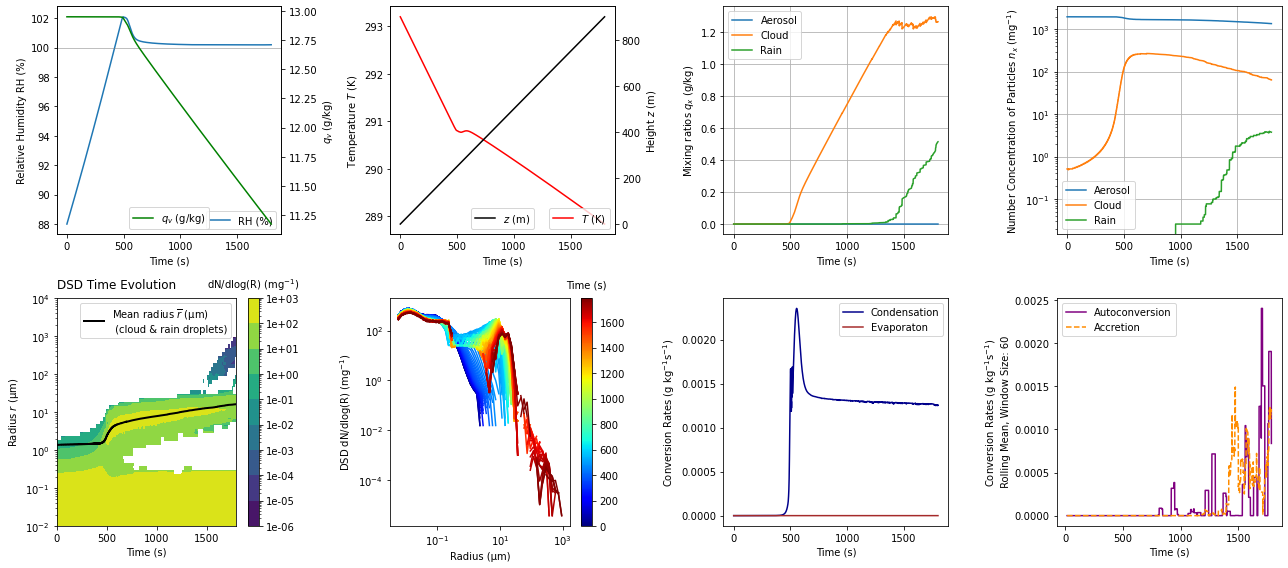

In [74]:
plot_mode=mode_plots_widget.value
subplot_array_function(plot_mode, dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, spectra_arr, increment_widget, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, rc_liq_avg_array)

## data output
options for saving output variables and drop size spectra, files will be written in the subfolder 'output'

In [29]:
file_name_header  = "TEST"

In [30]:
# save array of output variables into csv-file, optional filename can be given as filename='my_filename.csv'
save_model_output_variables(time_array, RH_parcel_array, q_parcel_array, T_parcel_array, z_parcel_array, qa_ts, \
                            qc_ts, qr_ts, na_ts, nc_ts, nr_ts, filename=file_name_header + '_testoutput_model.csv')

Output data written to: Output/TEST_testoutput_model.csv


In [31]:
# save array of DSD spectra per timesteps, combined with radii to csv-file
save_model_output_dsd(spectra_arr, rm_spec, rl_spec, rr_spec, nt, filename=file_name_header + '_dsd_array_output.csv')

Output data of droplet size distribution written to: Output/TEST_dsd_array_output.csv
